In [ ]:
# ✅ Confirm install
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)

from datasets import load_from_disk
from huggingface_hub import login
#import evaluate

from google.colab import drive
import os

import pandas as pd
import re

In [ ]:
root = '/content/drive'
drive.mount(root)

Mounted at /content/drive


In [ ]:
recipe_nlg_data_path = f'{root}/MyDrive/NLP-266/Project/RecipeNLG'

In [ ]:
dataset = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/oob_generated')

print(dataset)

Dataset({
    features: ['title', 'ingredients', 'directions', 'source', 'NER', 'n_ingredients', 'n_steps', 'n_ner', 'domain', 'avg_step_length', 'total_step_length', 'generated'],
    num_rows: 1000
})


In [ ]:
s = dataset['generated'][0]
r = dataset['directions'][0]
s

"1. Preheat oven to 375 degrees F (190 degrees C). Grease cookies sheets.\n2. In a large bowl, cream together 1 cup of shortening and 2 cups of white sugar until light and fluffy. Beat in 2 eggs one at a time, then stir in 1 cup of buttermilk, 1/2 cup of orange juice, and 2 tablespoons of orange zest.\n3. Combine 4 1/2 cups of all-purpose flour, 2 teaspoons of baking powder, 1 teaspoon of salt, and 1/2 teaspoon of baking soda; blend into the creamed mixture. Roll out dough to 1/2 inch thickness on a lightly floured surface. Cut with a cookie cutter and place on the prepared cookie sheets.\n4. Bake for 8 to 10 minutes in the preheated oven, or until edges are lightly browned. Cool completely before frosting.\n5. To make the frosting: melt 1/4 cup of butter, then add 4 cups of confectioners' sugar and 3 tablespoons of thawed orange juice concentrate. Stir until smooth, then spread on top of cooled cookies."

In [ ]:
def get_generated_instruction_list(batch):

  # find all "n."
  # split on "n."
  # Remove number from strings
  # Return list
  instructions = []
  instruction_starts = sorted([match.span() for match in re.finditer(r'\d+\.', batch['generated'])])
  for i, span in enumerate(instruction_starts):
    if i == len(instruction_starts) - 1:
      instruction = batch['generated'][span[-1]:]
    else:
      instruction = batch['generated'][span[-1]:instruction_starts[i+1][0]]

    instructions.append(instruction.strip())

  return {"generated_instruction_list": instructions}

def get_reference_instruction_list(batch):
  return {
          "reference_instruction_list": [
              directions.split('", "')
              for directions in batch["directions"]
              ]
      }

In [ ]:
import re

def get_generated_instruction_list(batch):
    generated_list = batch["generated"]
    all_instructions = []

    for text in generated_list:
        # Find all "n." (e.g., "1.", "2.", etc.)
        instruction_starts = sorted([match.span() for match in re.finditer(r'\d+\.', text)])
        instructions = []

        for i, span in enumerate(instruction_starts):
            if i == len(instruction_starts) - 1:
                instruction = text[span[-1]:]
            else:
                instruction = text[span[-1]:instruction_starts[i+1][0]]
            instructions.append(instruction.strip())

        all_instructions.append(instructions)

    return {"generated_instruction_list": all_instructions}


In [17]:
from scipy.stats import spearmanr
from torch.nn.functional import cosine_similarity
import numpy as np

def instruction_similarity(ref, gen):

    if len(gen) < 3:
      return 0

    ref_embed = model.encode(ref, convert_to_tensor=True).cpu()
    gen_embed = model.encode(gen, convert_to_tensor=True).cpu()

    sims = np.array(
        [
            [cosine_similarity(g, r, dim=0) for r in ref_embed]
            for g in gen_embed
        ]
    ) #g by r matrix

    generated_assignments = np.argmax(sims, axis=1)

    g_indices = np.arange(len(generated_assignments))

    corr, _ = spearmanr(g_indices, generated_assignments)

    return corr if not np.isnan(corr) else 0.0

In [18]:
from sentence_transformers import SentenceTransformer

model_id = 'multi-qa-MiniLM-L6-cos-v1'

# Load a model (change to a newer one if you like)
model = SentenceTransformer(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Sentences to encode
sentences = [
    "Sentence 1",
    "Sentence 2",
    "Sentence 3",
    "Sentence 4",
    "Sentence 5",
    "Sentence 6",
    "Sentence 7",
    "Sentence 8"
]

s1 = sentences.copy()
np.random.shuffle(sentences)
s2 = sentences

# Get dense embeddings (512-dimensional for most models)
embeddings = model.encode(sentences, convert_to_tensor=True)

sim = instruction_similarity(s1, s2)
sim

np.float64(-0.11904761904761905)

In [14]:
import numpy as np

def get_data_similarity_score(references, generated):
    scores = [instruction_similarity(r, g) for r, g in zip(references, generated)]
    return np.mean(scores)


In [15]:
def get_data_similarity_score_display(references, generated):
    pairs = zip(references, generated)
    scores = []
    for i, pair in enumerate(pairs):
        if i % 10 == 0:
          print(f"Pair {i}:")
        score = instruction_similarity(pair[0], pair[1])
        scores.append(score)
    return np.mean(scores)

In [ ]:
def extract_new_tokens(batch):
  return {"generated": batch['generated'].split("Recipe Instructions:")[-1].strip()}

In [ ]:
dataset = dataset.map(get_reference_instruction_list, batched=True, batch_size=32)
dataset = dataset.map(get_generated_instruction_list, batched=True, batch_size=32)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
r = dataset['reference_instruction_list']
g = dataset['generated_instruction_list']

In [ ]:
score = get_data_similarity_score_display(r, g)
score

Pair 0:
Pair 10:
Pair 20:
Pair 30:
Pair 40:
Pair 50:
Pair 60:
Pair 70:
Pair 80:
Pair 90:
Pair 100:
Pair 110:
Pair 120:
Pair 130:
Pair 140:
Pair 150:
Pair 160:
Pair 170:
Pair 180:
Pair 190:
Pair 200:
Pair 210:
Pair 220:
Pair 230:
Pair 240:
Pair 250:
Pair 260:
Pair 270:
Pair 280:
Pair 290:
Pair 300:
Pair 310:
Pair 320:
Pair 330:
Pair 340:


/tmp/ipython-input-7-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 350:
Pair 360:
Pair 370:
Pair 380:
Pair 390:
Pair 400:
Pair 410:
Pair 420:
Pair 430:
Pair 440:
Pair 450:
Pair 460:
Pair 470:
Pair 480:
Pair 490:
Pair 500:
Pair 510:
Pair 520:
Pair 530:
Pair 540:
Pair 550:
Pair 560:
Pair 570:
Pair 580:
Pair 590:
Pair 600:
Pair 610:
Pair 620:
Pair 630:
Pair 640:
Pair 650:
Pair 660:
Pair 670:
Pair 680:
Pair 690:
Pair 700:
Pair 710:
Pair 720:
Pair 730:
Pair 740:
Pair 750:
Pair 760:
Pair 770:
Pair 780:
Pair 790:
Pair 800:
Pair 810:
Pair 820:
Pair 830:
Pair 840:
Pair 850:
Pair 860:
Pair 870:
Pair 880:
Pair 890:
Pair 900:
Pair 910:
Pair 920:
Pair 930:
Pair 940:
Pair 950:
Pair 960:
Pair 970:
Pair 980:
Pair 990:


np.float64(0.43114224737298007)

In [ ]:
g[8]

[]

### CoT

In [ ]:
dataset = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/oob_cot_generated')

print(dataset)

Dataset({
    features: ['title', 'ingredients', 'directions', 'source', 'NER', 'n_ingredients', 'n_steps', 'n_ner', 'domain', 'avg_step_length', 'total_step_length', 'reasoning', 'generated'],
    num_rows: 1000
})


In [ ]:
dataset = dataset.map(get_reference_instruction_list, batched=True, batch_size=32)
dataset = dataset.map(get_generated_instruction_list, batched=True, batch_size=32)

r = dataset['reference_instruction_list']
g = dataset['generated_instruction_list']

score = get_data_similarity_score_display(r, g)
score

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Pair 1:
Pair 11:
Pair 21:
Pair 31:
Pair 41:
Pair 51:
Pair 61:
Pair 71:
Pair 81:
Pair 91:
Pair 101:
Pair 111:
Pair 121:
Pair 131:
Pair 141:
Pair 151:
Pair 161:
Pair 171:
Pair 181:
Pair 191:
Pair 201:
Pair 211:
Pair 221:
Pair 231:
Pair 241:
Pair 251:
Pair 261:
Pair 271:
Pair 281:
Pair 291:
Pair 301:
Pair 311:
Pair 321:


/tmp/ipython-input-82-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 331:
Pair 341:


/tmp/ipython-input-82-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 351:
Pair 361:
Pair 371:
Pair 381:
Pair 391:
Pair 401:
Pair 411:
Pair 421:
Pair 431:
Pair 441:
Pair 451:
Pair 461:
Pair 471:
Pair 481:
Pair 491:
Pair 501:
Pair 511:
Pair 521:
Pair 531:
Pair 541:
Pair 551:
Pair 561:
Pair 571:
Pair 581:
Pair 591:
Pair 601:
Pair 611:
Pair 621:
Pair 631:
Pair 641:
Pair 651:


/tmp/ipython-input-82-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 661:
Pair 671:
Pair 681:
Pair 691:
Pair 701:
Pair 711:
Pair 721:
Pair 731:


/tmp/ipython-input-82-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 741:
Pair 751:
Pair 761:
Pair 771:
Pair 781:
Pair 791:
Pair 801:


/tmp/ipython-input-82-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 811:
Pair 821:
Pair 831:
Pair 841:
Pair 851:
Pair 861:
Pair 871:
Pair 881:
Pair 891:
Pair 901:
Pair 911:
Pair 921:


/tmp/ipython-input-82-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 931:
Pair 941:
Pair 951:
Pair 961:
Pair 971:
Pair 981:
Pair 991:


np.float64(0.4468057627226189)

In [ ]:
oob_1_ret = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/oob_two_shot_retrieval_generated')

oob_1_ret = oob_1_ret.select(range(1000))

oob_1_ret = oob_1_ret.map(extract_new_tokens, batched=False)

oob_1_ret = oob_1_ret.map(get_reference_instruction_list, batched=True, batch_size=32)
oob_1_ret = oob_1_ret.map(get_generated_instruction_list, batched=True, batch_size=32)

r = oob_1_ret['reference_instruction_list']
g = oob_1_ret['generated_instruction_list']

score = get_data_similarity_score_display(r, g)
score

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Pair 0:
Pair 10:
Pair 20:
Pair 30:
Pair 40:
Pair 50:
Pair 60:
Pair 70:
Pair 80:


/tmp/ipython-input-7-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 90:
Pair 100:
Pair 110:
Pair 120:
Pair 130:
Pair 140:
Pair 150:
Pair 160:
Pair 170:
Pair 180:
Pair 190:
Pair 200:
Pair 210:
Pair 220:
Pair 230:
Pair 240:
Pair 250:
Pair 260:
Pair 270:
Pair 280:
Pair 290:
Pair 300:
Pair 310:
Pair 320:
Pair 330:
Pair 340:
Pair 350:
Pair 360:
Pair 370:
Pair 380:
Pair 390:
Pair 400:
Pair 410:
Pair 420:
Pair 430:
Pair 440:
Pair 450:
Pair 460:
Pair 470:
Pair 480:
Pair 490:
Pair 500:
Pair 510:
Pair 520:
Pair 530:
Pair 540:
Pair 550:
Pair 560:
Pair 570:
Pair 580:
Pair 590:
Pair 600:
Pair 610:
Pair 620:
Pair 630:
Pair 640:
Pair 650:
Pair 660:
Pair 670:
Pair 680:
Pair 690:
Pair 700:
Pair 710:
Pair 720:
Pair 730:
Pair 740:
Pair 750:
Pair 760:
Pair 770:
Pair 780:
Pair 790:
Pair 800:
Pair 810:
Pair 820:
Pair 830:
Pair 840:
Pair 850:
Pair 860:
Pair 870:
Pair 880:
Pair 890:
Pair 900:
Pair 910:
Pair 920:
Pair 930:
Pair 940:
Pair 950:
Pair 960:
Pair 970:
Pair 980:
Pair 990:


np.float64(0.5534538181259102)

In [ ]:
oob_1 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/oob_two_shot_generated')

oob_1 = oob_1.select(range(1000))

oob_1 = oob_1.map(extract_new_tokens, batched=False)

oob_1 = oob_1.map(get_reference_instruction_list, batched=True, batch_size=32)
oob_1 = oob_1.map(get_generated_instruction_list, batched=True, batch_size=32)

r = oob_1['reference_instruction_list']
g = oob_1['generated_instruction_list']

score = get_data_similarity_score_display(r, g)
score

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Pair 0:
Pair 10:
Pair 20:
Pair 30:
Pair 40:
Pair 50:
Pair 60:
Pair 70:


/tmp/ipython-input-7-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 80:
Pair 90:
Pair 100:
Pair 110:
Pair 120:
Pair 130:
Pair 140:
Pair 150:
Pair 160:
Pair 170:
Pair 180:
Pair 190:
Pair 200:
Pair 210:
Pair 220:
Pair 230:
Pair 240:
Pair 250:
Pair 260:
Pair 270:
Pair 280:
Pair 290:
Pair 300:
Pair 310:
Pair 320:
Pair 330:
Pair 340:
Pair 350:
Pair 360:
Pair 370:
Pair 380:
Pair 390:
Pair 400:
Pair 410:
Pair 420:
Pair 430:
Pair 440:
Pair 450:
Pair 460:
Pair 470:
Pair 480:
Pair 490:
Pair 500:
Pair 510:
Pair 520:
Pair 530:
Pair 540:
Pair 550:
Pair 560:
Pair 570:
Pair 580:
Pair 590:
Pair 600:
Pair 610:
Pair 620:
Pair 630:
Pair 640:
Pair 650:
Pair 660:
Pair 670:
Pair 680:
Pair 690:
Pair 700:
Pair 710:
Pair 720:
Pair 730:
Pair 740:
Pair 750:
Pair 760:
Pair 770:
Pair 780:
Pair 790:
Pair 800:
Pair 810:
Pair 820:
Pair 830:
Pair 840:
Pair 850:
Pair 860:
Pair 870:
Pair 880:
Pair 890:
Pair 900:
Pair 910:
Pair 920:
Pair 930:
Pair 940:
Pair 950:
Pair 960:
Pair 970:
Pair 980:
Pair 990:


np.float64(0.5253142002057549)

In [ ]:
from pprint import pprint
pprint(oob_1['generated'][0])

('1. Preheat oven to 350 degrees F (175 degrees C). Lightly grease a 9x13 inch '
 'baking dish.\n'
 '2. Arrange mushroom caps in the prepared baking dish.\n'
 '3. In a large bowl, mix together the clams, garlic, Parmesan cheese, onion, '
 'bread crumbs, green pepper, parsley, Italian-style seasoning, and black '
 'pepper. Spoon this mixture into the mushroom caps. Drizzle with butter and '
 'top with mozzarella cheese.\n'
 '4. Bake for 25 minutes in the preheated oven, or until golden brown on top.\n'
 '5. Serve hot or cold.')


In [ ]:
oob_1 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/oob_three_shot_retrieval_generated')

oob_1 = oob_1.select(range(1000))

oob_1 = oob_1.map(extract_new_tokens, batched=False)

oob_1 = oob_1.map(get_reference_instruction_list, batched=True, batch_size=32)
oob_1 = oob_1.map(get_generated_instruction_list, batched=True, batch_size=32)

r = oob_1['reference_instruction_list']
g = oob_1['generated_instruction_list']

score = get_data_similarity_score_display(r, g)
score

Pair 0:
Pair 10:
Pair 20:
Pair 30:
Pair 40:
Pair 50:
Pair 60:
Pair 70:


/tmp/ipython-input-6-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 80:
Pair 90:
Pair 100:
Pair 110:
Pair 120:
Pair 130:
Pair 140:
Pair 150:
Pair 160:
Pair 170:


/tmp/ipython-input-6-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 180:
Pair 190:


/tmp/ipython-input-6-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 200:
Pair 210:
Pair 220:
Pair 230:
Pair 240:
Pair 250:
Pair 260:
Pair 270:
Pair 280:
Pair 290:


/tmp/ipython-input-6-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 300:
Pair 310:
Pair 320:
Pair 330:
Pair 340:
Pair 350:
Pair 360:
Pair 370:


/tmp/ipython-input-6-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 380:
Pair 390:
Pair 400:
Pair 410:
Pair 420:
Pair 430:
Pair 440:
Pair 450:
Pair 460:
Pair 470:
Pair 480:
Pair 490:
Pair 500:
Pair 510:
Pair 520:
Pair 530:
Pair 540:
Pair 550:
Pair 560:
Pair 570:
Pair 580:


/tmp/ipython-input-6-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 590:
Pair 600:
Pair 610:
Pair 620:
Pair 630:
Pair 640:
Pair 650:
Pair 660:
Pair 670:
Pair 680:


/tmp/ipython-input-6-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 690:
Pair 700:
Pair 710:
Pair 720:
Pair 730:
Pair 740:
Pair 750:
Pair 760:
Pair 770:
Pair 780:
Pair 790:
Pair 800:
Pair 810:
Pair 820:
Pair 830:
Pair 840:
Pair 850:
Pair 860:


/tmp/ipython-input-6-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 870:
Pair 880:
Pair 890:
Pair 900:
Pair 910:
Pair 920:
Pair 930:
Pair 940:


/tmp/ipython-input-6-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 950:
Pair 960:
Pair 970:
Pair 980:


/tmp/ipython-input-6-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 990:


np.float64(0.534598287240813)

In [ ]:
pprint(oob_1['examples'][110])

['Recipe Title: Scalloped Potatoes\n'
 'Ingredients: ["Vegetable-oil cooking spray", "2 cups plus 2 tbsp plain rice '
 'milk (or skim milk)", "2 tbsp peeled almonds", "1/8 tsp freshly ground black '
 'pepper", "1 tsp minced roasted garlic", "1/2 tsp sea salt", "1/8 tsp ground '
 'nutmeg", "2 tbsp cornstarch", "3 russet potatoes, peeled and sliced as '
 'thinly as possible"]\n'
 'Recipe Instructions:\n'
 '1. "Preheat oven to 375F.\n'
 '2. Coat an 8\\" square pan with cooking spray.\n'
 '3. Combine 2 cups milk, almonds, pepper, garlic, salt, and nutmeg in blender '
 'and process until smooth.\n'
 '4. Pour into a medium saucepan and heat to low boil.\n'
 '5. In a small bowl, combine remaining 2 tbsp milk and cornstarch; whisk '
 'slowly into boiling sauce and stir until thickened, about 2 minutes.\n'
 '6. Place potato slices in large bowl and toss with sauce.\n'
 '7. Layer potatoes in baking pan and cover evenly with remaining sauce.\n'
 '8. Bake 15 to 20 minutes or until potatoes are sof

### Fine-Tuned

In [ ]:
oob_1 = load_from_disk(f'file://{recipe_nlg_data_path}/ft_generated')

oob_1 = oob_1.select(range(1000))

oob_1 = oob_1.map(extract_new_tokens, batched=False)

oob_1 = oob_1.map(get_reference_instruction_list, batched=True, batch_size=32)
oob_1 = oob_1.map(get_generated_instruction_list, batched=True, batch_size=32)

r = oob_1['reference_instruction_list']
g = oob_1['generated_instruction_list']

g_r = [[gen, ref] for gen, ref in zip(g, r) if len(gen) > 0]
g_clean = [gr[0] for gr in g_r]
r_clean = [gr[1] for gr in g_r]
get_data_similarity_score_display(g_clean, r_clean)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Pair 0:
Pair 10:


/tmp/ipython-input-6-1821717251.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Pair 20:
Pair 30:
Pair 40:
Pair 50:
Pair 60:
Pair 70:
Pair 80:
Pair 90:
Pair 100:
Pair 110:
Pair 120:
Pair 130:
Pair 140:
Pair 150:
Pair 160:
Pair 170:
Pair 180:
Pair 190:
Pair 200:
Pair 210:
Pair 220:
Pair 230:
Pair 240:
Pair 250:
Pair 260:
Pair 270:
Pair 280:
Pair 290:
Pair 300:
Pair 310:
Pair 320:
Pair 330:
Pair 340:
Pair 350:
Pair 360:
Pair 370:
Pair 380:
Pair 390:
Pair 400:
Pair 410:
Pair 420:
Pair 430:
Pair 440:
Pair 450:
Pair 460:
Pair 470:
Pair 480:
Pair 490:
Pair 500:
Pair 510:


np.float64(0.4195037455313583)

In [ ]:
ones = [gen for gen in g_clean if len(gen) == 1]


['Preheat oven to 350 degrees F (175 degrees C).']

In [ ]:
g[250]

[]

In [ ]:
r[250]

['["Arrange chicken in 8x4x2 inch baking dish.',
 'Drizzle butter over chicken.',
 'Bake at 375 degrees for 40 min.',
 'Place cooked and liquid removed broccoli around chicken.',
 'Blend soup, lowfat milk, and cheese; pour over chicken and broccoli.',
 'Top with bread crumbs and sprinkle with paprika.',
 'Bake 20 min longer.',
 'Yield: 2 servings."]']

2
3
4
5
6


/tmp/ipython-input-45-1938495497.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmans = [spearmanr(base, sublist).statistic for sublist in lists]


7
8
9


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from itertools import combinations_with_replacement
import numpy as np

In [ ]:
spearmanr([1,2,3,4], [1,1,2,2])

SignificanceResult(statistic=np.float64(0.8944271909999159), pvalue=np.float64(0.10557280900008414))

In [ ]:
def generate_monotonic_lists(n):
    """
    Generate all monotonic non-decreasing lists of length n
    using integers from 1 to n inclusive.
    """
    return list(combinations_with_replacement(range(1, n + 1), n))


In [ ]:
lows = []

for i in range(2, 11):
  print(i)
  base = list(range(1, i+1))
  lists = generate_monotonic_lists(i)
  spearmans = [spearmanr(base, sublist).statistic for sublist in lists]
  lows.append([a for a in spearmans if a > -1000])

2
3
4
5
6


/tmp/ipython-input-7-2729212384.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmans = [spearmanr(base, sublist).statistic for sublist in lists]


7
8
9
10


Text(0.5, 0, 'N')

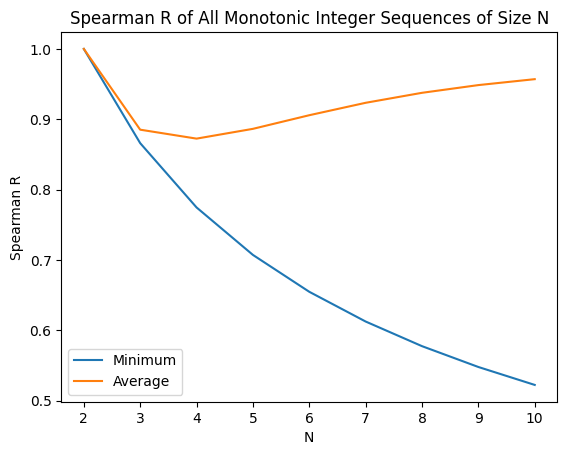

In [ ]:
x = list(range(2, 11))
mins = [min(low) for low in lows]
avgs = [np.mean(low) for low in lows]

plt.plot(x, mins, label='Minimum')
plt.plot(x, avgs, label='Average')

plt.legend()
plt.title("Spearman R of All Monotonic Integer Sequences of Size N")
plt.ylabel("Spearman R")
plt.xlabel("N")

In [4]:
!pip install evaluate rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c2a43d44566b67c5cd912e81ecec68d7aa668f090644898dafaa31ee135a2a5f
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [6]:
from rouge_score import rouge_scorer

In [13]:
ref = """Preheat the oven to 375°F.

Mix flour, sugar, and eggs in a bowl.

Pour the batter into a greased pan.

Bake for 25 minutes."""

gen = """Set your oven to 375 degrees Fahrenheit.

Combine eggs, sweetener, and flour inside mixer.

Transfer mixture to buttered baking dish.

Cook twenty-five minutes in the oven."""

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score(ref,
                      gen)
scores

{'rouge1': Score(precision=0.37037037037037035, recall=0.4, fmeasure=0.3846153846153846),
 'rougeL': Score(precision=0.2222222222222222, recall=0.24, fmeasure=0.23076923076923075)}

In [16]:
instruction_similarity(ref, gen)

NameError: name 'instruction_similarity' is not defined